In [1]:
%matplotlib inline
import matplotlib as mpl
import nuSQUIDSpy as nsq
import matplotlib.pyplot as plt

import nuSQUIDSTools
import numpy as np
import time as t

In [2]:
import glob
from PIL import Image 
#gif making module

In [3]:
units = nsq.Const()

In [4]:
E_1=np.geomspace(1,2,5)
E_2=np.geomspace(2,10,25)[1:]
E_3=np.geomspace(10,1000,25)[1:]
E_range_opt=np.append(np.append(E_1,E_2),E_3)

cth_neg_dense=np.append(np.linspace(-1,-0.8,20),np.linspace(-0.8,-0.76,15)[1:])
cth_neg=np.append(cth_neg_dense,np.linspace(-0.76,0.0,16)[1:])
cth_pos=np.linspace(0.0,1.0,5)[1:]
cos_range_opt=np.append(cth_neg,cth_pos)

# $\nu_\mu / \bar{\nu}_\mu$ oscillation probabilty/flux ratio plots. 3 vs 3+1 and check the impact of changing the mixing angles individually and combined (unitarity), pyfile that automatically runs that or contains a plotfunc

# plot flag = sterile, save plots as name_nu/anti_nu_14_x_24_y_34_z_spectrum_intialstate

In [5]:
inistate = 0 #e-nu=0, mu-nu=1, tau-nu=2 #both nu and anti nu equally

neutrino_flavors = 4 #3 for standard, 4 for sterile

#mixing angles in rad
th14 = 0.0 
th24 = 0.6
th34 = 0.0

#mass diffs in eV
masssqdiffsterile = 1.0

#power law params
Numnus = 1.0e18 #number of neutrinos
Power = -2.0 #scaling, 0 for equal distribution
Eflux = lambda E: Numnus*E**Power

trackangle = -1

## Create nuSQUIDS Object

In [6]:
interactions = True
energy_nodes=E_range_opt*units.GeV
cth_nodes = cos_range_opt

In [7]:
class ChangeMixingParams:
    '''
    works!
    two methods to change mixing params
    Angle(...) changes mixing angles
    Mass(...) changes difference mass squares
        
    '''    
    def __init__(self,nusq):
        self.nsq = nusq
    def Angle(self,i=0,j=1,value=0):
        '''
        changes angles of PMNS Matrix (extension with sterile)
        i<j ordered i.e. 1,2 but not 2,1
        i,4 is sterile angle
        value: angle in radians
        '''
        self.nsq.Set_MixingAngle(i,j,value)
    def Mass(self,i,value):
        '''
        changes difference of mass squares 
        i=1,2,3?
        i=3 is m14?
        '''
        self.nsq.Set_SquareMassDifference(i,value)
    def Default():
        '''
        resets changes to base nusquids
        '''
        self.nsq.Set_MixingParametersToDefault()

In [8]:
def SetIniFlux(nusq,nuflavor,initype,N0=1e18,power=-2.0,atmos=True):
    '''
    works!
    Sets the initial energy state for neutrinos in multiple energy mode in the flavor basis.
    nusq: nuSQUIDS Object
    nuflavor: neutrino flavor to be initialized as beginning state
    nutypes: Whether only (anti)neutrinos or both are considered
    initype: type of neu to be initialized, 0=neutrino,1=anti,"both"=both equally
    N0: number of neutrinos in power law spectrum
    power
    atmos: atmospheric mode (if True then array is expanded by cth_nodes)
    '''
    nutypes = nusq.GetNumRho() #number states of charge conj. (1 or 2)
    flavornum = nusq.GetNumNeu() #number of neutrino flavors
    E_nodes = nusq.GetERange()
    energy_nodes = nusq.GetERange()
    
    Eflux = lambda E: N0*E**power #define energy distr., cos equally distributed
    #define the intial array state
    if atmos == True:
        if nutypes==1:
            IniFlux = np.zeros((len(cth_nodes),len(E_nodes),flavornum))            
            for j,cos in enumerate(nusq.GetCosthRange()):
                for i,E in enumerate(nusq.GetERange()):
                    IniFlux[j][i][nuflavor] = Eflux(E) #only populates initial state with flux distr., rest is set to zero already
        if nutypes==2:
            IniFlux = np.zeros((len(nusq.GetCosthRange()),len(nusq.GetERange()),2,flavornum))
            if initype==0:
                for j,cos in enumerate(nusq.GetCosthRange()):
                    for i,E in enumerate(nusq.GetERange()):
                        IniFlux[j][i][0][nuflavor] = Eflux(E) #both neutrino and antineutrino
            if initype==1:
                for j,cos in enumerate(nusq.GetCosthRange()):
                    for i,E in enumerate(nusq.GetERange()):
                        IniFlux[j][i][1][nuflavor] = Eflux(E)
            if initype=="both":
                for j,cos in enumerate(nusq.GetCosthRange()):
                    for i,E in enumerate(nusq.GetERange()):
                        IniFlux[j][i][0][nuflavor] = Eflux(E) #both neutrino and antineutrino
                        IniFlux[j][i][1][nuflavor] = Eflux(E)
        
    if atmos == False:
        if nutypes==1:
            IniFlux = np.zeros((len(E_nodes),neutrino_flavors))
            for i,E in enumerate(nusq.GetERange()):
                IniFlux[i][nuflavor] = Eflux(E) #only populates initial state with flux distr., rest is set to zero already
        if nutypes==2:
            IniFlux = np.zeros((len(E_nodes),2,neutrino_flavors))
            if initype==0:
                for i,E in enumerate(nusq.GetERange()):
                    IniFlux[i][0][nuflavor] = Eflux(E) #only populates initial state with flux distr., rest is set to zero already
            if initype==1:
                for i,E in enumerate(nusq.GetERange()):
                    IniFlux[i][1][nuflavor] = Eflux(E)            
            if initype=="both":
                for i,E in enumerate(nusq.GetERange()):
                    IniFlux[i][0][nuflavor] = Eflux(E) #only populates initial state with flux distr., rest is set to zero already
                    IniFlux[i][1][nuflavor] = Eflux(E)            

    return IniFlux

In [9]:
def Labels(nsq,inistate,nutype,nom,power):
    '''
    works!
    creates a number of useful labels for plotting
    made for nuPlots
    nsq: nusquids object
    inistate: flavor number of the initialstate
    nutype: whether antimatter- or matter- (1 antimatter, 0 matter int) or "both" (string) neutrinos are desired
    nom,power: number of neutrinos and exponent describing their power law flux
    
    returns
    Elabel: Energy range labeled in GeV
    tr_probs: osc probability labels 
    flux labels: specific power law label
    '''

    numbertosymbol={0:r"e",1:r"\mu",2:r"\tau",3:r"4"}

    E0,E1 = round(nsq.GetERange()[0]),round(nsq.GetERange()[-1])
    Elabel = r"E={start}-{fin} GeV ".format(start=E0/1e9,fin=E1/1e9) #returns Erange assuming GeV as units
    
    isymbol=r"{symbol}".format(symbol=numbertosymbol[inistate])

    if nutype == 0:
        tr_prob_i1 = r"$P[\nu_{{{inumber}}} \to \nu_e$]".format(inumber=isymbol)
        tr_prob_i2 = r"$P[\nu_{{{inumber}}} \to \nu_\mu$]".format(inumber=isymbol)
        tr_prob_i3 = r"$P[\nu_{{{inumber}}} \to \nu_\tau$]".format(inumber=isymbol)
        tr_prob_i4 = r"$P[\nu_{{{inumber}}} \to \nu_4$]".format(inumber=isymbol)

        fluxlabel = r"$\Phi_{{\nu_{inumber}}} = {no} \cdot E^{{{po}}}$ initial".format(inumber=isymbol,no=Numnus,po=Power)
        
        #inilabel = r"$\nu_{{{inumber}}}$ initial".format(inumber=isymbol)
    if nutype == 1:
        tr_prob_i1 = r"$P[\bar{{\nu}}_{{{inumber}}} \to \bar{{\nu}}_e$]".format(inumber=isymbol)
        tr_prob_i2 = r"$P[\bar{{\nu}}_{{{inumber}}} \to \bar{{\nu}}_\mu$]".format(inumber=isymbol)
        tr_prob_i3 = r"$P[\bar{{\nu}}_{{{inumber}}} \to \bar{{\nu}}_\tau$]".format(inumber=isymbol)
        tr_prob_i4 = r"$P[\bar{{\nu}}_{{{inumber}}} \to \bar{{\nu}}_4$]".format(inumber=isymbol)
        
        fluxlabel = r"$\Phi_{{\bar{{\nu}}_{inumber}}} = {no} \cdot E^{{{po}}}$ initial".format(inumber=isymbol,no=Numnus,po=Power)
        
        #inilabel = r"$\bar_{{\nu}}_{{{inumber}}}$ initial".format(inumber=isymbol)
    if nutype == "both":
        tr_prob_i1 = r"$P[\nu_{{{inumber}}} + \bar{{\nu}}_{{{inumber}}} \to \nu_e + \bar{{\nu}}_e$]".format(inumber=isymbol)
        tr_prob_i2 = r"$P[\nu_{{{inumber}}} + \bar{{\nu}}_{{{inumber}}} \to \nu_\mu + \bar{{\nu}}_\mu$]".format(inumber=isymbol)
        tr_prob_i3 = r"$P[\nu_{{{inumber}}} + \bar{{\nu}}_{{{inumber}}} \to \nu_\tau + \bar{{\nu}}_\tau$]".format(inumber=isymbol)
        tr_prob_i4 = r"$P[\nu_{{{inumber}}} + \bar{{\nu}}_{{{inumber}}} \to \nu_4 + \bar{{\nu}}_4$]".format(inumber=isymbol)

        fluxlabel=r"$\Phi_{{\nu_{inumber}}},\Phi_{{\bar{{\nu}}_{inumber}}} = {no} \cdot E^{{{po}}}$ initial".format(inumber=isymbol,no=nom,po=power)  
        
        #inilabel = r"$\nu_{{{inumber}}},\bar{{\nu}}_{{{inumber}}}$ initial".format(inumber=isymbol)
        
    tr_probs=[tr_prob_i1,tr_prob_i2,tr_prob_i3]  
    
    if nsq.GetNumNeu()==4:
        tr_probs.append(tr_prob_i4)    
            
    return Elabel, tr_probs, fluxlabel #,inilabel

In [10]:
class nuPlots:
    '''
    works!
    has four methods:
    
    SaveFig:
    saves a figure to the specified path 
    
    HeatMap:
    PlotFlavor/HeatMap from the nuSQUIDSAtm class ext
    
    OscGram:
    Plots flux ratio (final vs initial) of 3 or 4 neutrinos
    
    Get_Flux:
    evaluates the flavor of a specific baseline specified by angle of a single neutrino type (neutrino 0 or antineutrino 1)
    '''
    
    def __init__(self, nusq):
        self.nsq = nusq #nusq_atm object
        
    def SaveFig(self,storagelocation,name): #saves figure
        '''
        saves plot to storagelocation/name.type
        e.g. Osc_Param_Test_Plots/test.png corresponds to
        storagelocation=Osc_Param_Test_Plots, has to be string
        name=test.png, has to be string
        NO NEED FOR / SEPARATION
        '''
        path=storagelocation+"/" #add / to end of path
        filename=name
        plt.savefig(path+filename+".png") 
        
    def HeatMap(self,neuflavor,neutype): #plots flux heatmap
        '''
        Plots Fluxes as Heatmap over cosTheta and Energy
        Calls PlotFlavor of the nuSQUIDS
        neuflavor=0,1,2,3 for e,mu,tau,4
        neutype=0,1 for neutrino,antineutrino
        '''
        self.nsq.PlotFlavor(neuflavor,neutype)
    def OscGram(self,trackangle,inistate,nutype,extralabel=False,save=False,nodespacing=[]): #plots osc gram
        '''
        plots the three fluxes per energy scale on as an oscillogram
        trackangle: angle of track (above pi/2 through earth)
        inistate: 0 e,1 mu, 2 tau,3 sterile
        nutype: 0 neu, 1 antineu, "both0" both initially neutrino oscgram, "both1" both initially antineu oscgram, added (TBA)
        extralabel: extra descr of oscgram in legend, e.g. mixing angle = ...
        save: tuple consisting of save folder and file name. No / separation between folder and name needed. Saves as a png.
        nodespacing: passed nodespacing for a different resolution due to interaction basis of mulitenergy mode (input list or array)
        
        E scale is GeV
        y scale is flux ratio of final to initial
        '''
        erange = self.nsq.GetERange() #grabs energyrange
        neutype = nutype #neutrino type (normal vs anti)
        nunum = self.nsq.GetNumNeu()
        typenum = self.nsq.GetNumRho()
        
        if list(nodespacing) and type(nodespacing) != bool: #checks if non empty array and if not True or False
            erange = np.array(nodespacing) #reconverts to numpy array
            
        if nutype == "both0": #sets neutrinotype for plotfluxes
            neutype=0
        if nutype == "both1":
            neutype=1      
            
        #grabs the fluxes for 3 nus for single existing nu type
        if typenum == 1:
            phi_e = np.array([self.nsq.EvalFlavor(0,trackangle,EE,neutype) for EE in erange]) 
            phi_mu = np.array([self.nsq.EvalFlavor(1,trackangle,EE,neutype) for EE in erange])
            phi_tau = np.array([self.nsq.EvalFlavor(2,trackangle,EE,neutype) for EE in erange])
        
            total = np.array(phi_e) + np.array(phi_mu) + np.array(phi_tau)
            
        
            if nunum == 4: #adds fourth for sterile
                phi_s = np.array([self.nsq.EvalFlavor(3,trackangle,EE) for EE in erange])
                total += np.array(phi_s)
        
        #grabs the fluxes for 3 nus for both types
        if typenum == 2:
            phi_e = np.array([self.nsq.EvalFlavor(0,trackangle,EE,neutype) for EE in erange]) 
            phi_mu = np.array([self.nsq.EvalFlavor(1,trackangle,EE,neutype) for EE in erange])
            phi_tau = np.array([self.nsq.EvalFlavor(2,trackangle,EE,neutype) for EE in erange])
        
            total = np.array(phi_e) + np.array(phi_mu) + np.array(phi_tau)
            
        
            if nunum == 4: #adds fourth for sterile
                phi_s = np.array([self.nsq.EvalFlavor(3,trackangle,EE,neutype) for EE in erange])
                total += np.array(phi_s)
        
        Elabel, tr_probs, fluxlabel = Labels(self.nsq,inistate,neutype,Numnus,Power)
        
        if nutype == "both0" or "both1":
            fluxlabel = Labels(self.nsq,inistate,"both",Numnus,Power)[2]
        
        tracklabel=r"$\Theta={tr}\pi$".format(tr=round(np.arccos(trackangle)/np.pi,2))
        
        plt.figure(figsize = (6,6))
        plt.plot(erange/units.GeV,phi_e/Eflux(erange), lw = 1.5, color = "blue", label =r"{elabel}".format(elabel=tr_probs[0]))
        plt.plot(erange/units.GeV,phi_mu/Eflux(erange), lw = 1.5, color = "red", label =r"{mulabel}".format(mulabel=tr_probs[1])) 
        plt.plot(erange/units.GeV,phi_tau/Eflux(erange), lw = 1.5, color = "green",label =r"{taulabel}".format(taulabel=tr_probs[2]))
        if nunum == 4:
            plt.plot(erange/units.GeV,phi_s/Eflux(erange), lw = 1.5, color = "purple", label =r"{fourlabel}".format(fourlabel=tr_probs[3]))
        plt.plot(erange/units.GeV,total/Eflux(erange), lw = 2.5, color = "black", label = r"$Total$")
        if extralabel != True and type(extralabel) != bool:
            plt.plot([], [], '', label=extralabel,color="none") # adds extralabel in box
        #print(total/Eflux(erange),Eflux(erange))
        plt.xscale('log')
        #plt.loglog()
        plt.xlim(erange[0]/units.GeV,erange[-1]/units.GeV)
        plt.xlabel(r"$E_\nu [{\rm GeV}]$")
        plt.ylabel(r"$\Phi_{final} / \Phi_{initial}$")
        plt.grid()
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize = 14, fancybox =True)
        
        if nunum == 3:
            plt.title(r"Atmosph. 3 $\nu$-osc."+', '+tracklabel+' ,'+Elabel+' ,'+fluxlabel)
        if nunum == 4:
            plt.title(r"Atmosph. 3+1 $\nu$-osc."+', '+tracklabel+' ,'+Elabel+' ,'+fluxlabel)
            
        if save != True and np.shape(save)==(2,) and type(save) != bool: #save is tupel of 
            storage, name = save
            plt.savefig(storage+"/"+name+".png", bbox_inches='tight')             
            
        plt.show()
        plt.close() #to prevent memory overrun        
        
    def Get_Flux(self,trackangle,nutype,nodespacing=[]):
        '''
        returns the flux (evalflavor) at theta=trackangle baseline of nutype 0: normal or anti: antineutrino
        '''
        erange = self.nsq.GetERange() #grabs energyrange
        neutype = nutype #neutrino type (normal:0 vs anti:1)
        nunum = self.nsq.GetNumNeu() #3 or 4 etc.
        typenum = self.nsq.GetNumRho() #one type or anti and neu
        
        if list(nodespacing) and type(nodespacing) != bool: #checks if non empty array and if not True or False
            erange = np.array(nodespacing) #reconverts to numpy array
            
        #grabs the fluxes for 3 nus for single existing nu type
        if typenum == 1:
            phi_e = np.array([self.nsq.EvalFlavor(0,trackangle,EE,neutype) for EE in erange]) 
            phi_mu = np.array([self.nsq.EvalFlavor(1,trackangle,EE,neutype) for EE in erange])
            phi_tau = np.array([self.nsq.EvalFlavor(2,trackangle,EE,neutype) for EE in erange])
        
            total = np.array(phi_e) + np.array(phi_mu) + np.array(phi_tau)
            
        
            if nunum == 4: #adds fourth for sterile
                phi_s = np.array([self.nsq.EvalFlavor(3,trackangle,EE) for EE in erange])
                total += np.array(phi_s)
        
        #grabs the fluxes for 3 nus for both types
        if typenum == 2:
            phi_e = np.array([self.nsq.EvalFlavor(0,trackangle,EE,neutype) for EE in erange]) 
            phi_mu = np.array([self.nsq.EvalFlavor(1,trackangle,EE,neutype) for EE in erange])
            phi_tau = np.array([self.nsq.EvalFlavor(2,trackangle,EE,neutype) for EE in erange])
        
            total = np.array(phi_e) + np.array(phi_mu) + np.array(phi_tau)
            
        
            if nunum == 4: #adds fourth for sterile
                phi_s = np.array([self.nsq.EvalFlavor(3,trackangle,EE,neutype) for EE in erange])
                total += np.array(phi_s)
                
        if nunum == 3:
            return np.array([phi_e,phi_mu,phi_tau,total])
        
        if nunum == 4:
            return np.array([phi_e,phi_mu,phi_tau,phi_s,total])

In [11]:
'''
works!
'''

def FigsToGifPNG(frame_location,savename):
    '''
    savename: name of the gif
    frame_location: PATH to folder with frames of the SVG frames
    '''
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_location}/*.PNG"))] #frames from folder i.e. each gif new folder, sorts by name
    frame_one = frames[0]
    frame_one.save("name.gif".format(name = savename), format="GIF", append_images=frames,
               save_all=True, duration=len(frames)*500, loop=0) #time in ms, here 0.5s per frame
    
def FigsToGifJPG(frame_location,savename):
    '''
    savename: name of the gif
    frame_location: PATH to folder with frames of the SVG frames
    '''
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_location}/*.JPG"))] #frames from folder i.e. each gif new folder, sorts by name
    frame_one = frames[0]
    frame_one.save("name.gif".format(name = savename), format="GIF", append_images=frames,
               save_all=True, duration=len(frames)*500, loop=0) #time in ms, here 0.5s per frame

In [12]:
nodes_1_2 = 6 #1-2 GeV
nodes_2_8 = 14 #2-5 GeV
nodes_8_40 = 20 #5-20 GeV
nodes_40_10000 = 50 #20-10000 GeV

def NewNodes(node_multiplier):
    New_nodes = []
    New_nodes = np.append(New_nodes,np.geomspace(1,2,int(node_multiplier*nodes_1_2)))
    New_nodes = np.append(New_nodes,np.geomspace(2,8,int(node_multiplier*nodes_2_8))[1:])
    New_nodes = np.append(New_nodes,np.geomspace(8,40,int(node_multiplier*nodes_8_40))[1:])
    New_nodes = np.append(New_nodes,np.geomspace(40,1e4,int(node_multiplier*nodes_40_10000))[1:])
    return New_nodes*units.GeV

In [13]:
nodeseries = NewNodes(2)

# Plot Series 1

todo:
naming rule
gifmake check
plot series
also anti

In [14]:
Theta23_range=np.linspace(30,60,11)/180*np.pi
m23sq_range=np.linspace(1,3,11)*1e-3 #mass range

In [15]:
E_range=np.geomspace(1,10000,101)
costheta_range=cos_range_opt

In [16]:
E_range = nodeseries/units.GeV

## Test $\Theta_{23}$ range

In [17]:
th23plotflag = False

In [18]:
energy_nodes=E_range*units.GeV
cth_nodes = np.linspace(-1,1,21)
interactions = False
neutrino_flavors = 3
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries1/Theta23"

if th23plotflag == True:

    for th in Theta23_range:

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)

        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Angle(1,2,th) # sets mixing angle to value in Theta23_range

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        thlabel = r"$\Theta_{{23}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legend

        name="{thval}_th23_neu_mu_ini_newnodes".format(thval="%.3f" % round(th,3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots

        save = (savefolder, name) #tuple for image save of neu osc gram

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",thlabel,save); #neutrino muon -> osc gram

        antiname="{thval}_th23_antineu_mu_ini_newnodes".format(thval="%.3f" % round(th,3)) #antineutrino file names
        nametemp=antiname.partition('.') 
        antiname=nametemp[0]+nametemp[2]

        antisave = (savefolder, antiname) #tuple for image save of antineu osc gram

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",thlabel,antisave); #antineutrino muon -> osc gram    

## Test $\Delta m_{23}$ range

In [19]:
m23plotflag = False

In [20]:
energy_nodes=E_range*units.GeV
cth_nodes = np.linspace(-1,1,21)
interactions = False
neutrino_flavors = 3
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries1/m23"

if m23plotflag == True:

    for m in m23sq_range:
        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)

        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(2,m) # sets sq mass diff diff m23^2 ~ diff m13^2

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-10) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-10)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        m23label = r"$\Delta_{{m_{{23}}}}^{{2}}={test}\cdot$ 1e-3 eV$^2$".format(test=round(m/1e-3,3)) #extra label with specific 23 angle for plot legend

        name="{mval}e-3_m23_neu_mu_ini_newnodes".format(mval="%.3f" % round(m/1e-3,3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots

        save = (savefolder, name) #tuple for image save of antineu osc gram

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",m23label,save) #neutrino muon -> osc gram

        antiname="{mval}e-6_m23_antineu_mu_ini_newnodes".format(mval="%.3f" % round(m/1e-3,3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname) #tuple for image save of antineu osc gram

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",m23label,antisave) #antineutrino muon -> osc gram        

## Test both at once

In [21]:
thm23plotflag = False

In [22]:
energy_nodes=E_range*units.GeV
cth_nodes = np.linspace(-1,1,21)
interactions = False
neutrino_flavors = 3
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries1/ThM23"

if thm23plotflag == True:

    for i in range(len(Theta23_range)):

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(2,m23sq_range[i]) # sets sq mass diff diff m23^2 ~ diff m13^2
        MixParams.Angle(1,2,Theta23_range[i])

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-7) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-7)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        m23label = r"$\Delta_{{m_{{23}}}}^{{2}}={test} \cdot$ 1e-3 eV$^2$".format(test=round(m23sq_range[i]/1e-3,3)) #extra label with specific 23 angle for plot legend
        thlabel = r"$\Theta_{{23}}={test}$".format(test=round(Theta23_range[i],3)) #extra label with specific 23 angle for plot legend

        exlabel=m23label+'\n '+thlabel

        name="{}e-3_m23_{}_Th23_neu_mu_ini_newnodes".format(round(m23sq_range[i]/1e-3,3),round(Theta23_range[i],3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="{}e-3_m23_{}_Th23_antineu_mu_ini_newnodes".format(round(m23sq_range[i]/1e-3,3),round(Theta23_range[i],3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

# Plot Series 2 (sterile)

In [23]:
Theta14_range=np.linspace(5,45,9)/180*np.pi
Theta24_range=np.linspace(5,45,9)/180*np.pi
Theta34_range=np.linspace(5,45,9)/180*np.pi
dm14=1.0

# $ \Theta_{14}-\nu_\mu$ series

In [24]:
th14plotflag = False
E_range_sterile=nodeseries

In [25]:
energy_nodes=E_range_sterile
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th14"

if th14plotflag == True:
    for th in Theta14_range:

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m14^2=1ev^2
        MixParams.Angle(0,3,th) #sets mixing angle 14 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{14}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th14_sneu_mu_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th14_antisneu_mu_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

# $ \Theta_{24}-\nu_\mu$ series

In [26]:
th24plotflag = False

In [27]:
energy_nodes=E_range_sterile
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th24"

if th24plotflag == True:
    for th in Theta24_range:

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m24^2=1ev^2
        MixParams.Angle(1,3,th) #sets mixing angle 24 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{24}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th24_sneu_mu_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th24_antisneu_mu_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

# $\Theta_{34}-\nu_\mu$ series

In [28]:
th34plotflag = False

In [29]:
energy_nodes=E_range_sterile
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th34"

if th34plotflag == True:
    for th in Theta34_range:

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(2,3,th) #sets mixing angle 34 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{34}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th34_sneu_mu_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th34_antisneu_mu_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

# Two $\Theta$ interference

In [30]:
th1424plotflag = False

In [31]:
energy_nodes=E_range_sterile
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th_14_24"

if th1424plotflag == True:
    for i in range(len(Theta14_range)):

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(0,3,Theta14_range[i]) #sets mixing angle 34 to th value in range
        MixParams.Angle(1,3,Theta24_range[i]) #sets mixing angle 34 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{14}},\Theta_{{24}}={test}$".format(test=round(Theta14_range[i],3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th14_Th24_sneu_mu_ini_newnodes".format(round(Theta14_range[i],3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th14_Th24_antisneu_mu_ini_newnodes".format(round(Theta24_range[i],3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

In [32]:
th1434plotflag = False

In [33]:
energy_nodes=E_range_sterile
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th_14_34"

if th1424plotflag == True:
    for i in range(len(Theta14_range)):

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(0,3,Theta14_range[i]) #sets mixing angle 34 to th value in range
        MixParams.Angle(2,3,Theta34_range[i]) #sets mixing angle 34 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{14}},\Theta_{{34}}={test}$".format(test=round(Theta14_range[i],3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th14_Th34_sneu_mu_ini_newnodes".format(round(Theta14_range[i],3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th14_Th34_antisneu_mu_ini_newnodes".format(round(Theta34_range[i],3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

In [34]:
th2434plotflag = False

In [35]:
energy_nodes=E_range_sterile
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th_24_34"

if th1424plotflag == True:
    for i in range(len(Theta14_range)):

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(1,3,Theta24_range[i]) #sets mixing angle 34 to th value in range
        MixParams.Angle(2,3,Theta34_range[i]) #sets mixing angle 34 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{24}},\Theta_{{34}}={test}$".format(test=round(Theta24_range[i],3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th24_Th34_sneu_mu_ini_newnodes".format(round(Theta14_range[i],3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th24_Th34_antisneu_mu_ini_newnodes".format(round(Theta34_range[i],3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

# Three $ \Theta $ interference

In [36]:
th142434plotflag = False

In [37]:
energy_nodes=E_range_sterile
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th_14_24_34"

if th142434plotflag == True:
    for i in range(len(Theta14_range)):

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(0,3,Theta14_range[i]) #sets mixing angle 34 to th value in range
        MixParams.Angle(1,3,Theta24_range[i]) #sets mixing angle 34 to th value in range
        MixParams.Angle(2,3,Theta34_range[i]) #sets mixing angle 34 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{14}},\Theta_{{24}},\Theta_{{34}}={test}$".format(test=round(Theta24_range[i],3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th14_24_Th34_sneu_mu_ini_newnodes".format(round(Theta14_range[i],3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th14_24_Th34_antisneu_mu_ini_newnodes".format(round(Theta34_range[i],3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

## Plotseries 2 Verification plots

## $\Theta_{14},\Theta_{24}$ plots in slow and high prec. and merge

In [38]:
energy_nodes=E_range_sterile
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

In [39]:
precplotflag = False

In [40]:
th = 45/360*2*np.pi

savefolder = "Osc_Param_Test_Plots/VerTest/PrecTest"

if precplotflag == True:

    for i in range(4,10):

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(0,3,th) #sets mixing angle 14 to th value
        MixParams.Angle(1,3,th) #sets mixing angle 24 to th value

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(10**(-i)) #evolves state
        nsq_atmTh.Set_abs_error(10**(-i))
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s")

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{14}},\Theta_{{24}}={test}, rel./abs. err= 1e-{prec}$".format(test=round(th,3),prec=i) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_45_Th1424_e-{}_prec_sneu_mu_ini_newnodes".format(round(i,0)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_45_Th1424_e-{}_prec_antisneu_mu_ini_newnodes".format(round(i,0)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

In [41]:
energy_nodes=E_range_sterile=np.append(E_range_opt,np.geomspace(1e3,1e4,10))*units.GeV
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th24"

showplot = False

if showplot == True:

    th=45/180*np.pi

    nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
    nsq_atmTh.Set_MixingParametersToDefault()
    MixParams=ChangeMixingParams(nsq_atmTh)
    MixParams.Mass(3,1.) # sets delta m24^2=1ev^2
    MixParams.Angle(2,3,th) #sets mixing angle 24 to th value in range

    IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
    nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

    temp=t.time()
    nsq_atmTh.Set_rel_error(1.0e-6) #evolves state
    nsq_atmTh.Set_abs_error(1.0e-6)
    nsq_atmTh.EvolveState()
    print(t.time()-temp,"s") 

    mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
    thlabel = r"$\Theta_{{24}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legend

    exlabel=mlabel+'\n '+thlabel

    name="1ev_m14_{}_Th24_sneu_mu_ini_newnodes".format(round(th,3)) #name as neu with 
    nametemp=name.partition('.') #separates into multiple strings on dots
    name=nametemp[0]+nametemp[2] #joins string together without dots   

    Plots0=nuPlots(nsq_atmTh)
    Plots0.OscGram(trackangle,1,"both0",exlabel) #neutrino muon -> osc gram

    antiname="1ev_m14_{}_Th24_antisneu_mu_ini_newnodes".format(round(th,3)) #name as neu with 
    nametemp=antiname.partition('.') #separates into multiple strings on dots
    antiname=nametemp[0]+nametemp[2] #joins string together without dots

    Plots1=nuPlots(nsq_atmTh)
    Plots1.OscGram(trackangle,1,"both1",exlabel) #antineutrino muon -> osc gram    
    
    snuFlux = Plots0.Get_Flux(trackangle,0)
    antisnuFlux = Plots1.Get_Flux(trackangle,1)

In [42]:
N0=1e18
Eflux = lambda E: N0*E**-2

In [43]:
saveplot = False

if saveplot == True:

    snu_3_flux,snu_4_flux=snuFlux[2:4]
    fig = plt.figure(figsize=(21,7))
    axes = plt.subplot(1,2,1)
    axes.plot(energy_nodes/units.GeV,snu_3_flux/snu_4_flux,'+',label=r"$\Phi_{{\nu_{{\tau}}}}/\Phi_{{\nu_{{4}}}}$")
    axes.set_xlabel(r'E [GeV]')
    axes.set_ylabel(r'Flux in [GeV]$^{-2}$')
    antisnu_3_flux,antisnu_4_flux=antisnuFlux[2:4]
    axes.plot(energy_nodes/units.GeV,antisnu_3_flux/antisnu_4_flux,'+',label=r"$\Phi_{{\bar{{\nu}}_{{\tau}}}}/\Phi_{{\bar{{\nu}}_{{4}}}}$")
    axes.legend(fontsize="14")
    axes.set_xscale('log')
    axes.set_xlabel(r'E [GeV]')
    axes.set_ylabel(r'Flux ratio in [GeV]$^{-2}$')
    axes.set_title(r'$\Theta_{{14}},\Theta_{{24}}$=45 deg')
    plt.savefig("Osc_Param_Test_Plots/VerTest/FluxMerge/th1424_45deg_fluxmerge.png")
    plt.show()

## Optimization of node spacing

In [44]:
oldnode_multiplier = 1
E_1=np.geomspace(1,2,oldnode_multiplier*5)*units.GeV
E_2=np.geomspace(2,10,oldnode_multiplier*25)[1:]*units.GeV
E_3=np.geomspace(10,1000,oldnode_multiplier*25)[1:]*units.GeV
E_4=np.geomspace(1000,10000,oldnode_multiplier*20)[1:]*units.GeV
oldnodes=np.append(np.append(E_1,E_2),np.append(E_3,E_4))

nodes_1_2 = 6 #1-2 GeV
nodes_2_8 = 14 #2-5 GeV
nodes_8_40 = 20 #5-20 GeV
nodes_40_10000 = 50 #20-10000 GeV

New_nodes = NewNodes(2)

In [45]:
th = 45/360*2*np.pi

savefolder = "Osc_Param_Test_Plots/VerTest/NodeTest"

nodes=[oldnodes,New_nodes]
nodename=["oldnodes","newnodes"]

nodeplot = False

if nodeplot == True:

    for i in range(len(nodes)):

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,oldnodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(0,3,th) #sets mixing angle 14 to th value
        MixParams.Angle(1,3,th) #sets mixing angle 24 to th value

        IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)
        temp=t.time()
        nsq_atmTh.Set_rel_error(1e-5) #evolves state
        nsq_atmTh.Set_abs_error(1e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s")

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{14}},\Theta_{{24}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_45_Th1424_{}_sneu_mu_ini_newnodes".format(nodename[i]) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,1,"both0",exlabel,save,nodes[i]) #neutrino muon -> osc gram

        antiname="1ev_m14_45_Th1424_{}_antisneu_mu_ini_newnodes".format(nodename[i]) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,1,"both1",exlabel,antisave,nodes[i]) #antineutrino muon -> osc gram    

In [46]:
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

th = 10/180*np.pi

interpolplotflag = False

if interpolplotflag == True:

    nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,oldnodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
    nsq_atmTh.Set_MixingParametersToDefault()
    MixParams=ChangeMixingParams(nsq_atmTh)
    MixParams.Mass(3,1.) # sets delta m24^2=1ev^2
    MixParams.Angle(1,3,th) #sets mixing angle 24 to th value in range

    IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
    nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

    temp=t.time()
    nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
    nsq_atmTh.Set_abs_error(1.0e-5)
    nsq_atmTh.EvolveState()
    print(t.time()-temp,"s") 

    mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
    thlabel = r"$\Theta_{{24}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legend

    exlabel=mlabel+'\n '+thlabel

    Plots0=nuPlots(nsq_atmTh)
    Plots0.OscGram(trackangle,1,"both0",exlabel,False,New_nodes) #neutrino muon -> osc gram

    Flux0=Plots0.Get_Flux(trackangle,0)

    Plots1=nuPlots(nsq_atmTh)
    Plots1.OscGram(trackangle,1,"both1",exlabel,False,New_nodes) #antineutrino muon -> osc gram   

    Flux1=Plots0.Get_Flux(trackangle,1)


    nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,New_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
    nsq_atmTh.Set_MixingParametersToDefault()
    MixParams=ChangeMixingParams(nsq_atmTh)
    MixParams.Mass(3,1.) # sets delta m24^2=1ev^2
    MixParams.Angle(1,3,th) #sets mixing angle 24 to th value in range

    IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
    nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

    temp=t.time()
    nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
    nsq_atmTh.Set_abs_error(1.0e-5)
    nsq_atmTh.EvolveState()
    print(t.time()-temp,"s") 

    mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
    thlabel = r"$\Theta_{{24}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legend

    exlabel=mlabel+'\n '+thlabel

    Plots0=nuPlots(nsq_atmTh)
    Plots0.OscGram(trackangle,1,"both0",exlabel,False) #neutrino muon -> osc gram

    Flux0_1=Plots0.Get_Flux(trackangle,0)

    Plots1=nuPlots(nsq_atmTh)
    Plots1.OscGram(trackangle,1,"both1",exlabel,False) #antineutrino muon -> osc gram   

    Flux1_1=Plots0.Get_Flux(trackangle,1)

## Interpolation error deviation test

In [47]:
interpolerr_flag = False

In [48]:
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

th = 10/180*np.pi

nodes_1 = oldnodes
nodes_2 = NewNodes(2)

Fluxmodel = Eflux(nodes_2)

In [49]:
if interpolerr_flag == True:
    nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,nodes_1,neutrino_flavors,nsq.NeutrinoType.both,interactions)
    nsq_atmTh.Set_MixingParametersToDefault()
    MixParams=ChangeMixingParams(nsq_atmTh)
    MixParams.Mass(3,1.) # sets delta m24^2=1ev^2
    MixParams.Angle(1,3,th) #sets mixing angle 24 to th value in range

    IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
    nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

    temp=t.time()
    nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
    nsq_atmTh.Set_abs_error(1.0e-5)
    nsq_atmTh.EvolveState()
    print(t.time()-temp,"s") 

    Plots0=nuPlots(nsq_atmTh)
    Flux_1=Plots0.Get_Flux(trackangle,0,nodes_2) #flux when interpolating nodes_2 from nodes_1 start

    nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,nodes_2,neutrino_flavors,nsq.NeutrinoType.both,interactions) #using tighter nodespacing
    nsq_atmTh.Set_MixingParametersToDefault()
    MixParams=ChangeMixingParams(nsq_atmTh)
    MixParams.Mass(3,1.) # sets delta m24^2=1ev^2
    MixParams.Angle(1,3,th) #sets mixing angle 24 to th value in range

    IFlux=SetIniFlux(nsq_atmTh,1,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
    nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

    temp=t.time()
    nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
    nsq_atmTh.Set_abs_error(1.0e-5)
    nsq_atmTh.EvolveState()
    print(t.time()-temp,"s") 

    Plots1=nuPlots(nsq_atmTh)
    Flux_2=Plots1.Get_Flux(trackangle,0) #flux using nodes_2 to begin with and no interpolation

In [50]:
if interpolerr_flag == True: #plotsection
    
    phi_e_1, phi_mu_1, phi_tau_1, phi_s_1, total_1 = Flux_1
    phi_e_2, phi_mu_2, phi_tau_2, phi_s_2, total_2 = Flux_2

    interpol_ratio = total_1/Fluxmodel # divides total flux with interpolation by fluxmodel to determine excess

    Flux_mod = Flux_1 / interpol_ratio #renormalizes interpolated flux with ratio

    abs_dev = Flux_mod - Flux_2 #normalized flux - non interpolated
    rel_dev = abs_dev / Flux_2

    abs_e, abs_mu, abs_tau, abs_s, abs_tot = abs_dev
    rel_e, rel_mu, rel_tau, rel_s, rel_tot = np.abs(rel_dev)

    Elabel, tr_probs, fluxlabel = Labels(nsq_atmTh,1,1,Numnus,Power)
    fluxlabel = Labels(nsq_atmTh,1,"both",Numnus,Power)[2]
    tracklabel=r"$\Theta={tr}\pi$".format(tr=round(np.arccos(trackangle)/np.pi,2))

    mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
    thlabel = r"$\Theta_{{24}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legen
    exlabel=mlabel+'\n '+thlabel

    plt.figure(figsize = (6,6))
    plt.plot(nodes_2/units.GeV,abs_e/Fluxmodel, lw = 1., color = "blue",label=r"$\bar{{\nu}}_{e}$")
    plt.plot(nodes_2/units.GeV,abs_mu/Fluxmodel, lw = 1., color = "red",label=r"$\bar{{\nu}}_{\mu}$") 
    plt.plot(nodes_2/units.GeV,abs_tau/Fluxmodel, lw = 1., color = "green",label=r"$\bar{{\nu}}_{\tau}$")
    plt.plot(nodes_2/units.GeV,abs_s/Fluxmodel, lw = 1., color = "purple",label=r"$\bar{{\nu}}_{s}$")
    plt.plot(nodes_2/units.GeV,abs_tot/Fluxmodel, lw = 2., color = "black",label=r"Total")
    plt.plot([],'',label=exlabel,color='white')
    plt.xscale('log')
    plt.xlim(nodes_2[0]/units.GeV,nodes_2[-1]/units.GeV)
    plt.ylabel(r"$\Delta \Phi_\bar{\nu}$ (normalized interpol.-normal)")
    plt.xlabel(r"E [GeV]")
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize = 14, fancybox =True)

    plt.title(r"Atmosph. 3+1 $\nu$-osc."+', '+tracklabel+' ,'+Elabel+' ,'+fluxlabel)

    storage, name = ("Osc_Param_Test_Plots/VerTest/NodeTest","absolute_deviation")
    plt.savefig(storage+"/"+name+".png", bbox_inches='tight')             

    plt.show()
    #plt.close() #to prevent memory overrun       

    Elabel, tr_probs, fluxlabel = Labels(nsq_atmTh,1,1,Numnus,Power)
    fluxlabel = Labels(nsq_atmTh,1,"both",Numnus,Power)[2]
    tracklabel=r"$\Theta={tr}\pi$".format(tr=round(np.arccos(trackangle)/np.pi,2))

    mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
    thlabel = r"$\Theta_{{24}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legen
    exlabel=mlabel+'\n '+thlabel

    plt.figure(figsize = (6,6))
    plt.plot(nodes_2/units.GeV,rel_e, lw = 2., color = "blue",label=r"$\bar{{\nu}}_{e}$")
    plt.plot(nodes_2/units.GeV,rel_mu, lw = 2., color = "red",label=r"$\bar{{\nu}}_{\mu}$") 
    plt.plot(nodes_2/units.GeV,rel_tau, lw = 2., color = "green",label=r"$\bar{{\nu}}_{\tau}$")
    plt.plot(nodes_2/units.GeV,rel_s, lw = 2., color = "purple",label=r"$\bar{{\nu}}_{s}$")
    plt.plot([],'',label=exlabel,color='white')
    plt.loglog()
    plt.xlim(nodes_2[0]/units.GeV,nodes_2[-1]/units.GeV)
    plt.ylim(np.min(np.abs(rel_dev[0:4][np.abs(rel_dev[0:4])>0]))/2/2,np.max(np.abs(rel_dev))*2)
    plt.ylabel(r"$\Delta \Phi_\bar{\nu} / \Phi_\bar{\nu}$ (interpolated-normal)")
    plt.xlabel(r"E [GeV]")
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize = 14, fancybox =True)

    plt.title(r"Atmosph. 3+1 $\nu$-osc."+', '+tracklabel+' ,'+Elabel+' ,'+fluxlabel)

    storage, name = ("Osc_Param_Test_Plots/VerTest/NodeTest","relative_deviation")
    plt.savefig(storage+"/"+name+".png", bbox_inches='tight')             

    plt.show()
    #plt.close() #to prevent memory overrun       

## $\nu_e$-series

In [51]:
singleth_e_plotflag = False #changing one th_ij
multith_e_plotflag = False #changing multiple th_ij at once

In [52]:
E_range_sterile=nodeseries

In [53]:
costheta_range=cos_range_opt
E_range = nodeseries/units.GeV

In [54]:
energy_nodes=E_range_sterile
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th14"

if singleth_e_plotflag == True:
    for th in Theta14_range:

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m14^2=1ev^2
        MixParams.Angle(0,3,th) #sets mixing angle 14 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,0,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{14}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th14_sneu_e_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,0,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th14_antisneu_e_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,0,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

In [55]:
savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th24"

if singleth_e_plotflag == True:
    for th in Theta24_range:

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m24^2=1ev^2
        MixParams.Angle(1,3,th) #sets mixing angle 24 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,0,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{24}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th24_sneu_e_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,0,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th24_antisneu_e_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,0,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

In [56]:
savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th34"

if singleth_e_plotflag == True:
    for th in Theta34_range:

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(2,3,th) #sets mixing angle 34 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,0,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{34}}={test}$".format(test=round(th,3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th34_sneu_e_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,0,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th34_antisneu_e_ini_newnodes".format(round(th,3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,0,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

In [57]:
savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th_14_24"

if multith_e_plotflag == True:
    for i in range(len(Theta14_range)):

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(0,3,Theta14_range[i]) #sets mixing angle 34 to th value in range
        MixParams.Angle(1,3,Theta24_range[i]) #sets mixing angle 34 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,0,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{14}},\Theta_{{24}}={test}$".format(test=round(Theta14_range[i],3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th14_Th24_sneu_e_ini_newnodes".format(round(Theta14_range[i],3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,0,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th14_Th24_antisneu_e_ini_newnodes".format(round(Theta24_range[i],3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,0,"both1",exlabel,antisave) #antineutrino muon -> osc gram    
        
savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th_14_34"

if multith_e_plotflag == True:
    for i in range(len(Theta14_range)):

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(0,3,Theta14_range[i]) #sets mixing angle 34 to th value in range
        MixParams.Angle(2,3,Theta34_range[i]) #sets mixing angle 34 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,0,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{14}},\Theta_{{34}}={test}$".format(test=round(Theta14_range[i],3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th14_Th34_sneu_e_ini_newnodes".format(round(Theta14_range[i],3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,0,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th14_Th34_antisneu_e_ini_newnodes".format(round(Theta34_range[i],3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,0,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th_24_34"

if multith_e_plotflag == True:
    for i in range(len(Theta14_range)):

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(1,3,Theta24_range[i]) #sets mixing angle 34 to th value in range
        MixParams.Angle(2,3,Theta34_range[i]) #sets mixing angle 34 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,0,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{24}},\Theta_{{34}}={test}$".format(test=round(Theta24_range[i],3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th24_Th34_sneu_e_ini_newnodes".format(round(Theta14_range[i],3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,0,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th24_Th34_antisneu_e_ini_newnodes".format(round(Theta34_range[i],3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,0,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

106.47117686271667 s


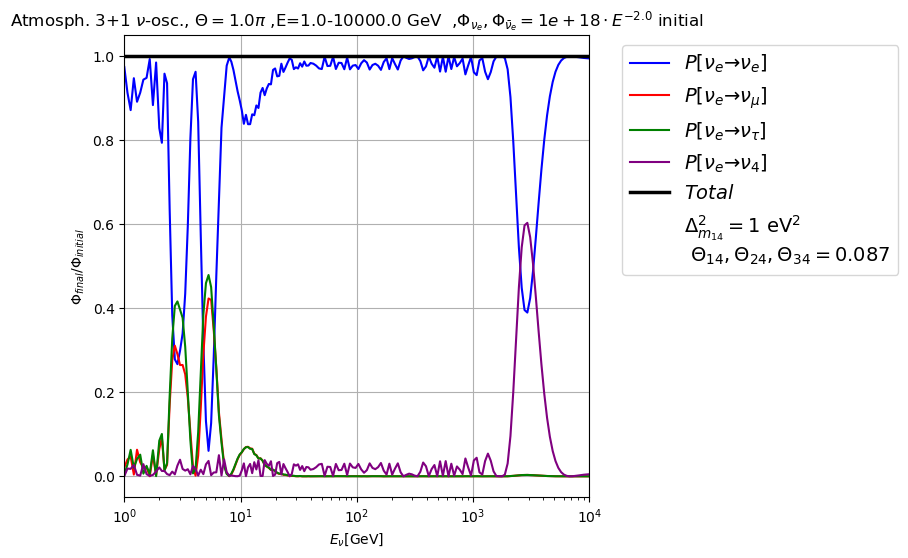

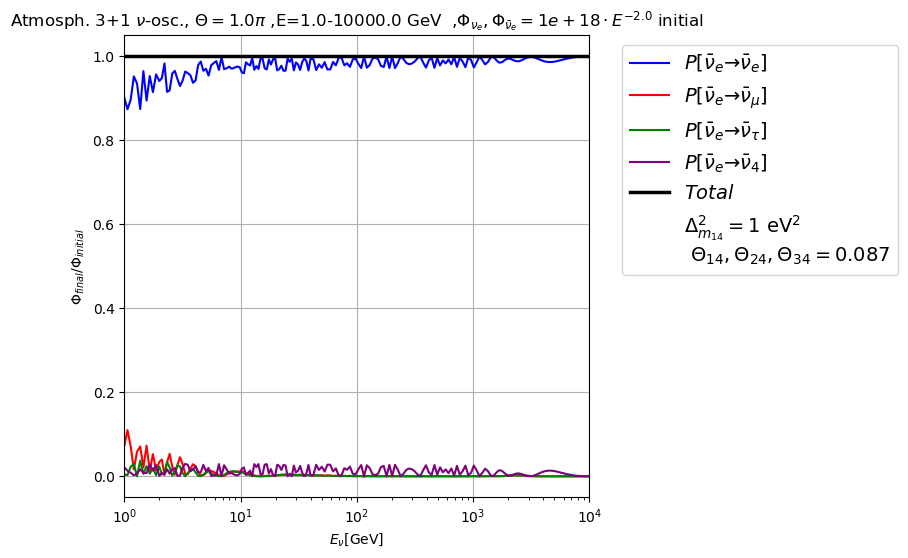

133.39438319206238 s


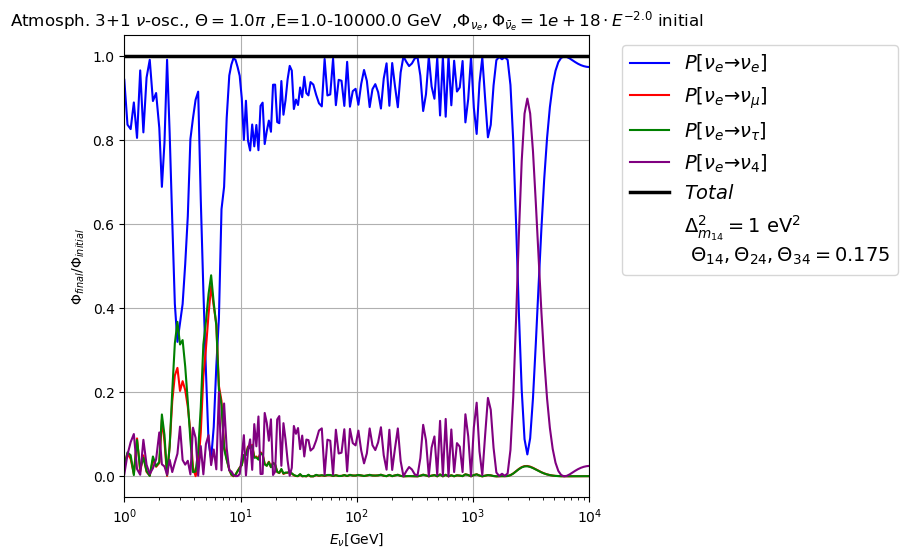

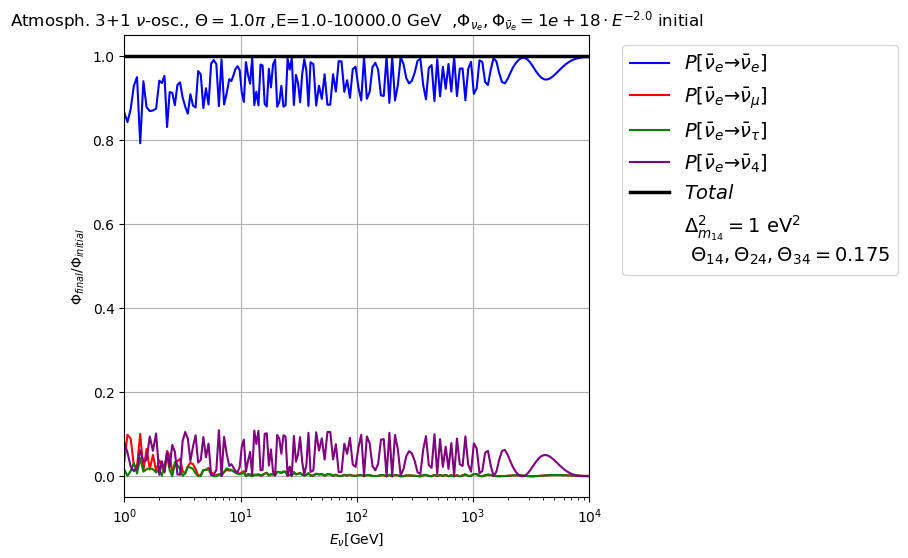

147.43071722984314 s


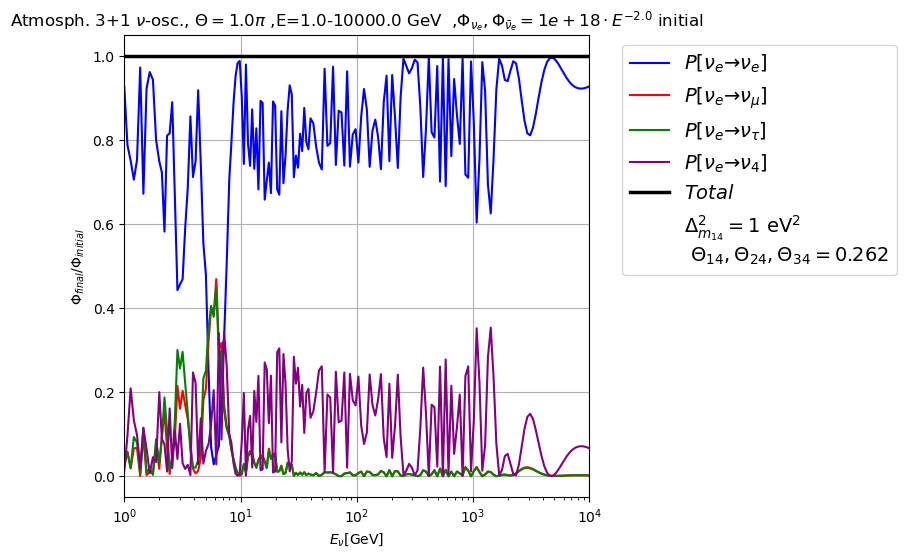

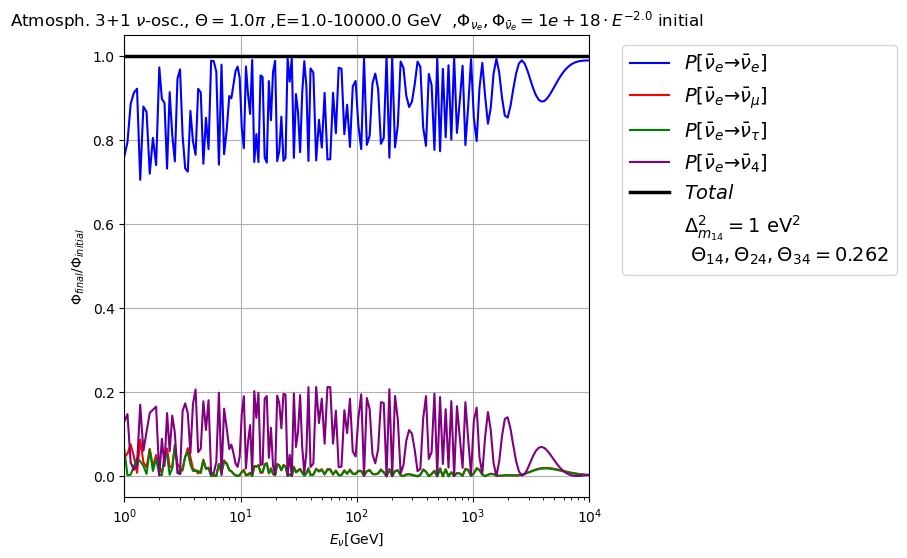

153.5220808982849 s


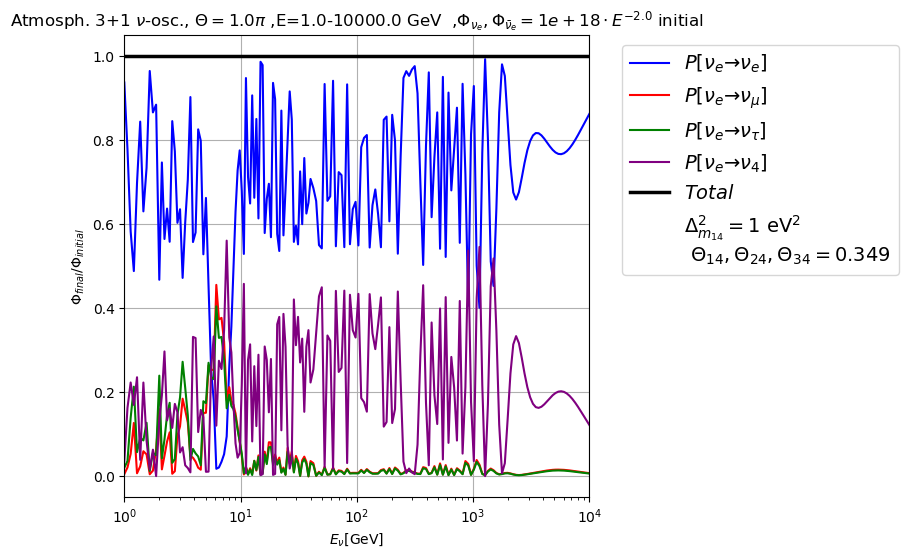

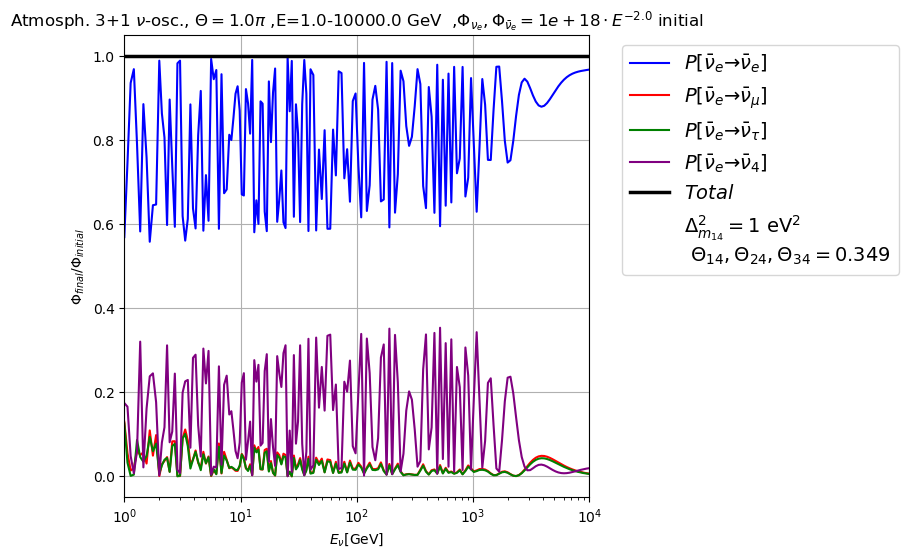

162.12032961845398 s


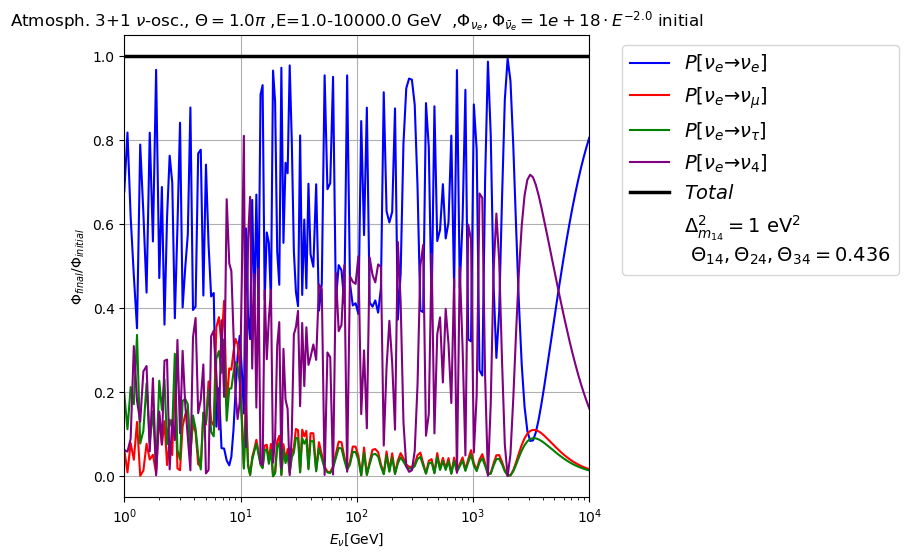

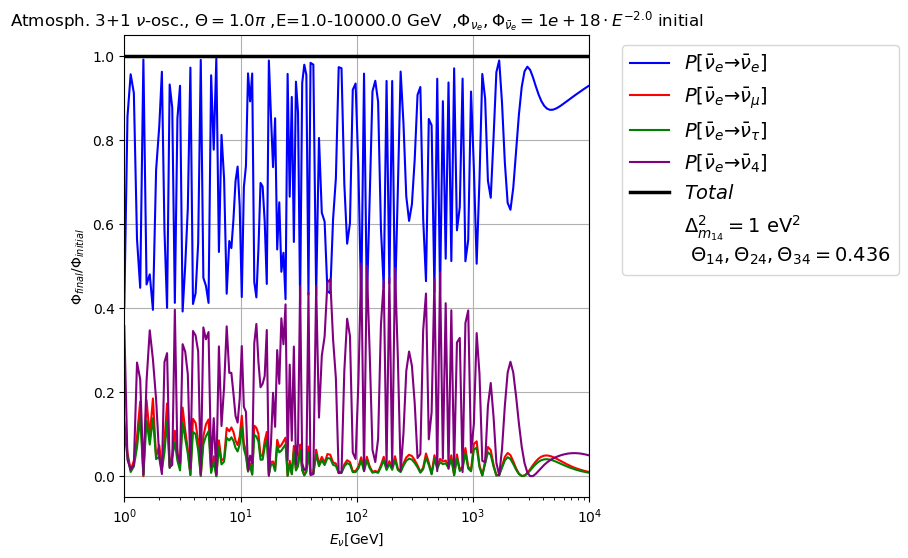

172.37215113639832 s


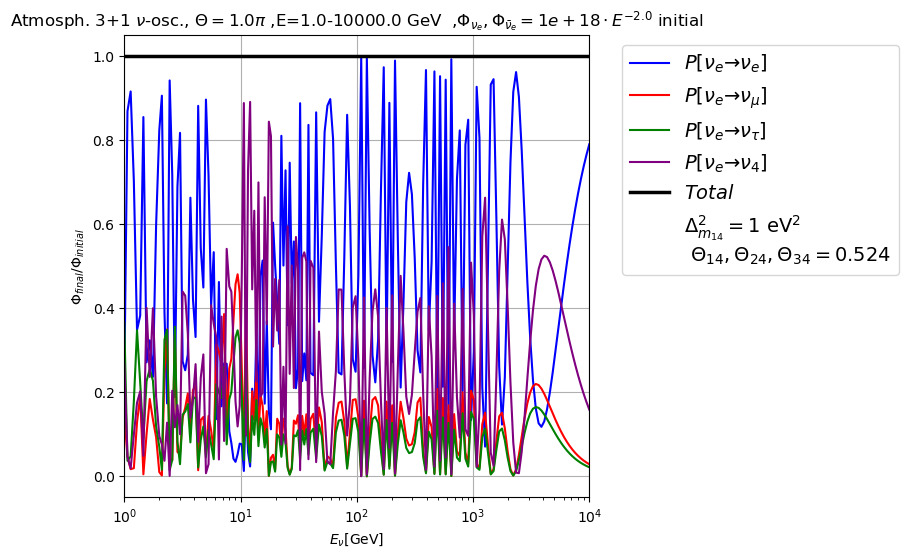

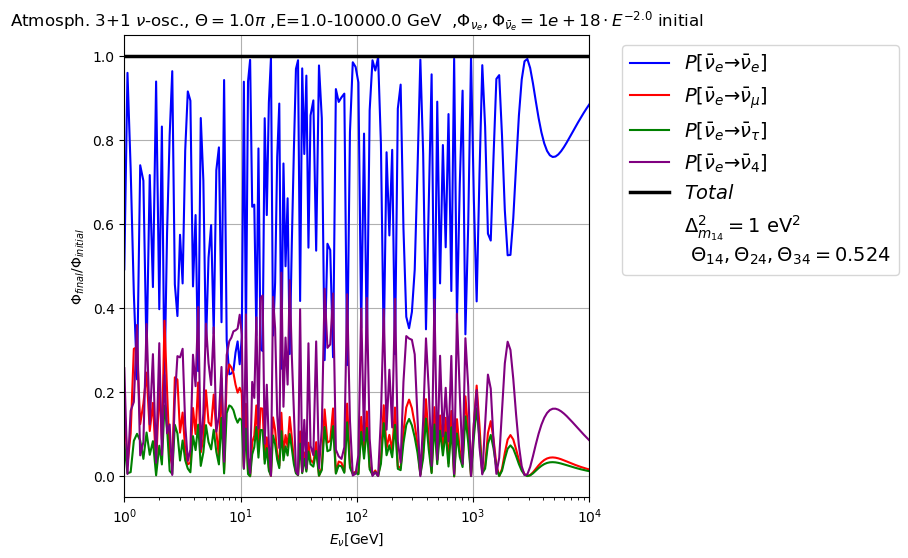

178.65187239646912 s


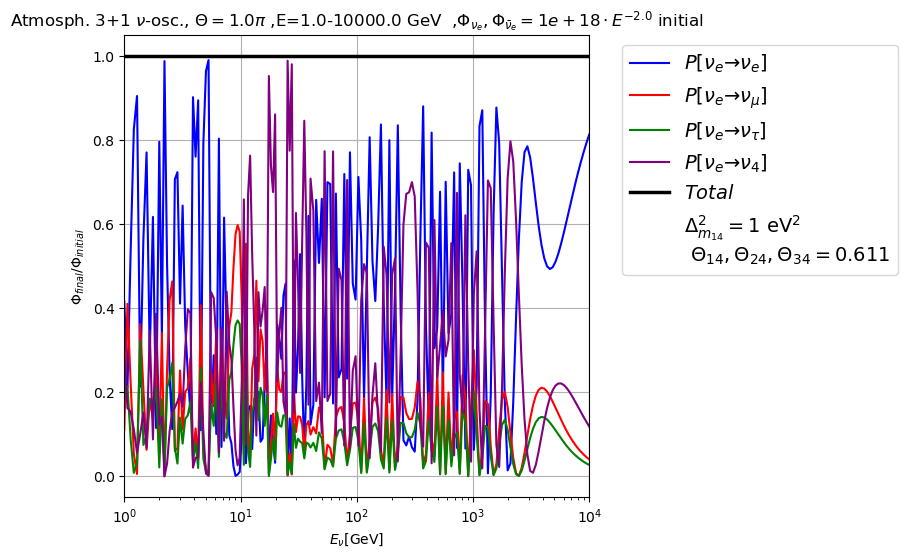

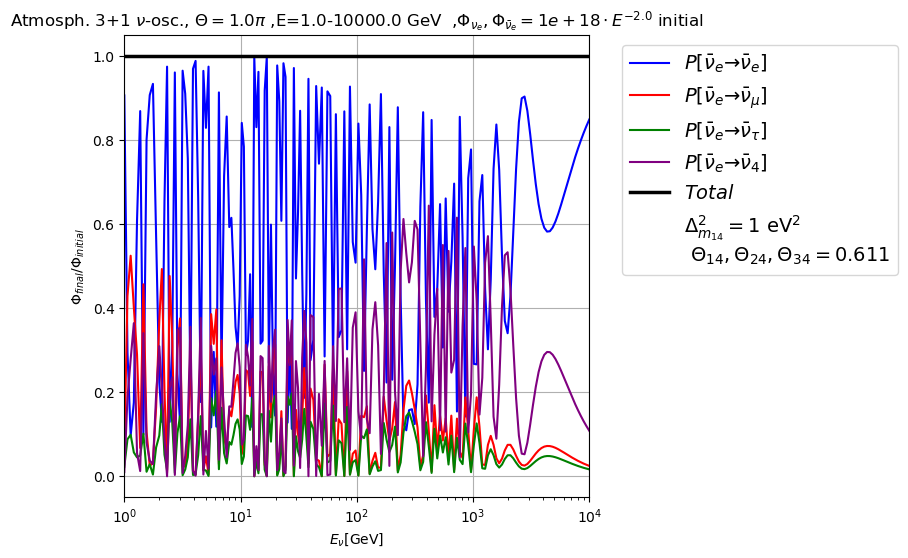

178.4602394104004 s


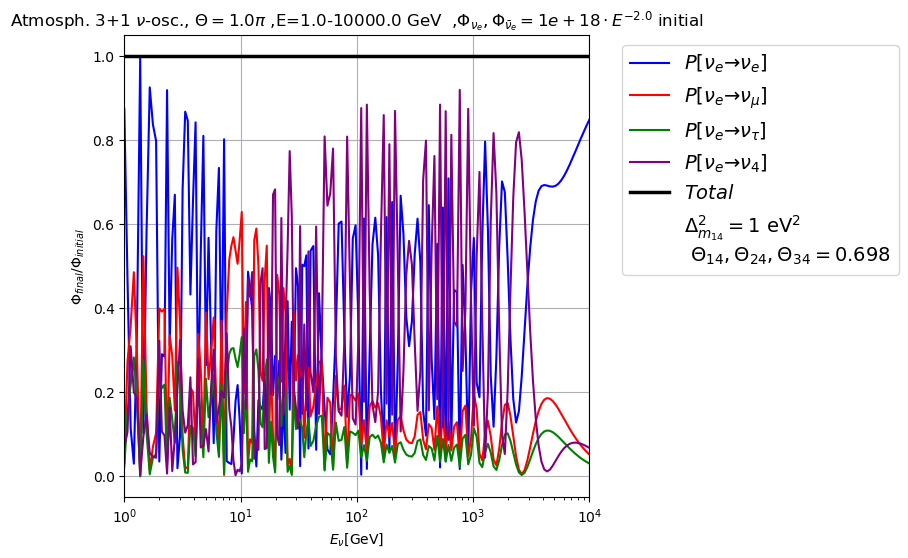

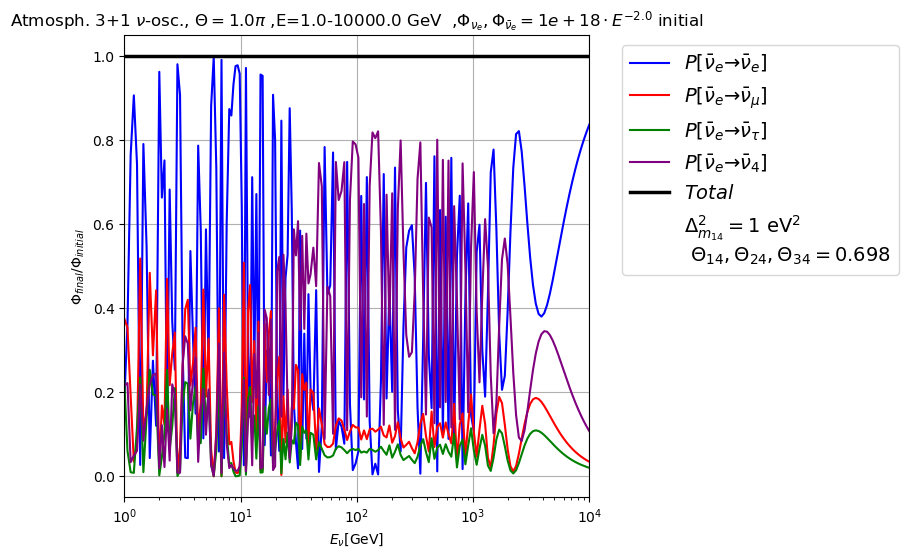

182.80014038085938 s


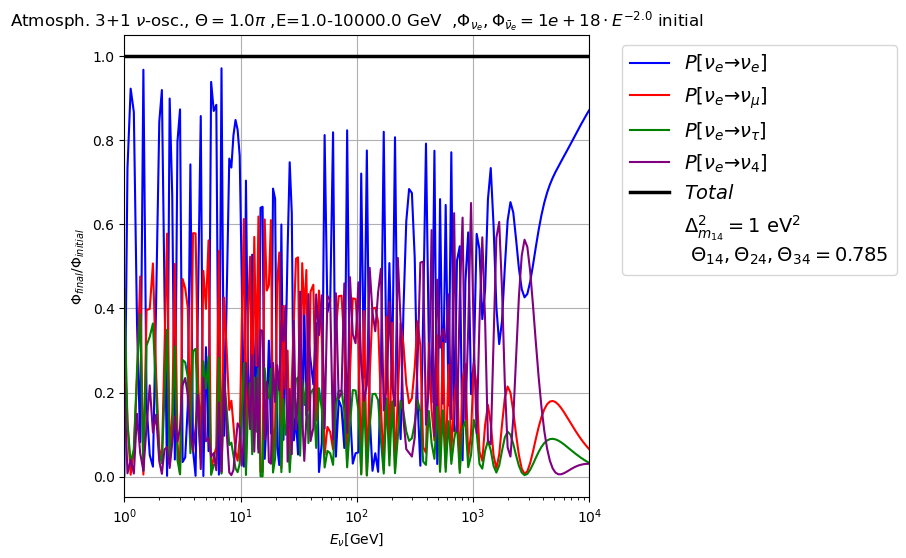

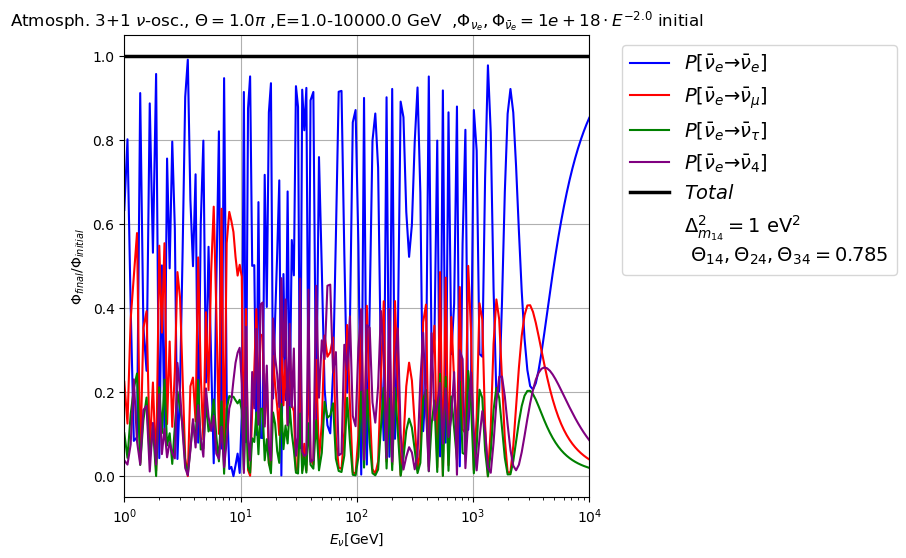

In [60]:
energy_nodes=E_range_sterile
cth_nodes = cos_range_opt
interactions = False
neutrino_flavors = 4 #sterile
trackangle = -1.0

savefolder = "Osc_Param_Test_Plots/PlotSeries2/Th_14_24_34"

if multith_e_plotflag == True:
    for i in range(len(Theta14_range)):

        nsq_atmTh =nuSQUIDSTools.ExtNuSQUIDSAtm(cth_nodes,energy_nodes,neutrino_flavors,nsq.NeutrinoType.both,interactions)
        nsq_atmTh.Set_MixingParametersToDefault()
        MixParams=ChangeMixingParams(nsq_atmTh)
        MixParams.Mass(3,1.) # sets delta m34^2=1ev^2
        MixParams.Angle(0,3,Theta14_range[i]) #sets mixing angle 34 to th value in range
        MixParams.Angle(1,3,Theta24_range[i]) #sets mixing angle 34 to th value in range
        MixParams.Angle(2,3,Theta34_range[i]) #sets mixing angle 34 to th value in range

        IFlux=SetIniFlux(nsq_atmTh,0,"both",Numnus,Power) #intial 1e18*E**-2 flux for muon+antimuon state
        nsq_atmTh.Set_initial_state(IFlux,nsq.Basis.flavor)

        temp=t.time()
        nsq_atmTh.Set_rel_error(1.0e-5) #evolves state
        nsq_atmTh.Set_abs_error(1.0e-5)
        nsq_atmTh.EvolveState()
        print(t.time()-temp,"s") 

        mlabel = r"$\Delta_{{m_{{14}}}}^{{2}}=1$ eV$^2$" #sterile mass label
        thlabel = r"$\Theta_{{14}},\Theta_{{24}},\Theta_{{34}}={test}$".format(test=round(Theta24_range[i],3)) #extra label with specific 23 angle for plot legend

        exlabel=mlabel+'\n '+thlabel

        name="1ev_m14_{}_Th14_24_Th34_sneu_e_ini_newnodes".format(round(Theta14_range[i],3)) #name as neu with 
        nametemp=name.partition('.') #separates into multiple strings on dots
        name=nametemp[0]+nametemp[2] #joins string together without dots   

        save = (savefolder, name)

        Plots0=nuPlots(nsq_atmTh)
        Plots0.OscGram(trackangle,0,"both0",exlabel,save) #neutrino muon -> osc gram

        antiname="1ev_m14_{}_Th14_24_Th34_antisneu_e_ini_newnodes".format(round(Theta34_range[i],3)) #name as neu with 
        nametemp=antiname.partition('.') #separates into multiple strings on dots
        antiname=nametemp[0]+nametemp[2] #joins string together without dots

        antisave = (savefolder, antiname)

        Plots1=nuPlots(nsq_atmTh)
        Plots1.OscGram(trackangle,0,"both1",exlabel,antisave) #antineutrino muon -> osc gram    

In [3]:
!tar chvfz notebook.tar.gz

tar: Cowardly refusing to create an empty archive
Try `tar --help' or `tar --usage' for more information.
